# Testing Sandbox (CAS)

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import trackpy as tp
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.animation as animation
import os

import tracker
import stats
import visualizer
import utils

import importlib

## Load the Video

True
(1024, 1024, 3)


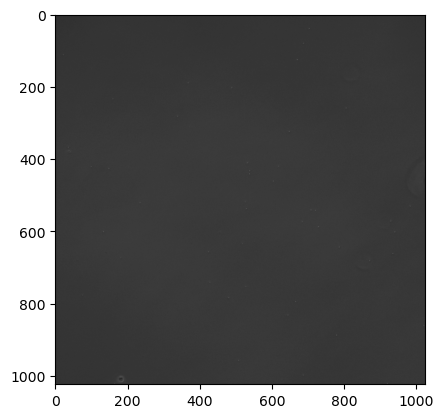

 the dimensions of the image are: (1024, 1024)


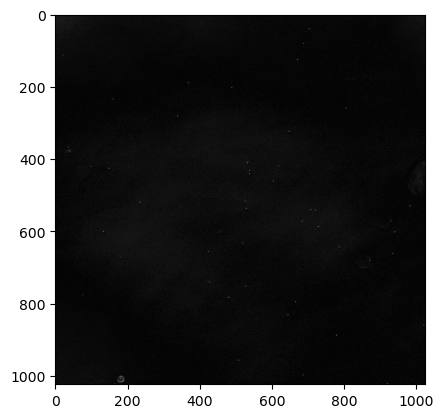

In [78]:
videofile = "Videos/5X Ph 9Fps Wash 1 16 120S P019as R1.mp4"

print(os.path.exists(videofile))  # Should print True if the file exists; may indicate issue with file path or import if false

# Visualize the input
cap = cv.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

# Print the dimensions of the image
print(frame.shape)

# show the image
plt.imshow(frame); plt.show()

# Simple pre-processing routine
# Convert to grayscale
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
print(f' the dimensions of the image are: {gray.shape}')

# Determine the median grayscale value
mid_val = np.median(gray)

# Show an image with median correction
plt.imshow(np.abs(gray-mid_val),cmap='gray'); plt.show()

In [79]:
# Make an adjusted video with median correction
import cv2 as cv
import numpy as np
import os

def process_and_save_video(source_video):
    # Initialize the video capture
    cap = cv.VideoCapture(source_video)

    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get the width and height of frames
    frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(cap.get(cv.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv.VideoWriter_fourcc(*'h264')
    output_path = os.path.splitext(source_video)[0] + '_adj.mp4'
    out = cv.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height), isColor=False)

    # Process each frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # Calculate median value
        mid_val = np.median(gray)
        # Subtract the median from the grayscale image and ensure it stays in valid range
        adjusted_frame = cv.convertScaleAbs(np.abs(gray - mid_val))

        # Write the modified frame to the new video file
        out.write(adjusted_frame)

    # Release everything when job is finished
    cap.release()
    out.release()
    print(f"New video file saved: {output_path}")

# Path to the source video file
source_video = videofile
process_and_save_video(source_video)

New video file saved: Videos/5X Ph 9Fps Wash 1 16 120S P019as R1_adj.mp4


## Autothresholding Visualization

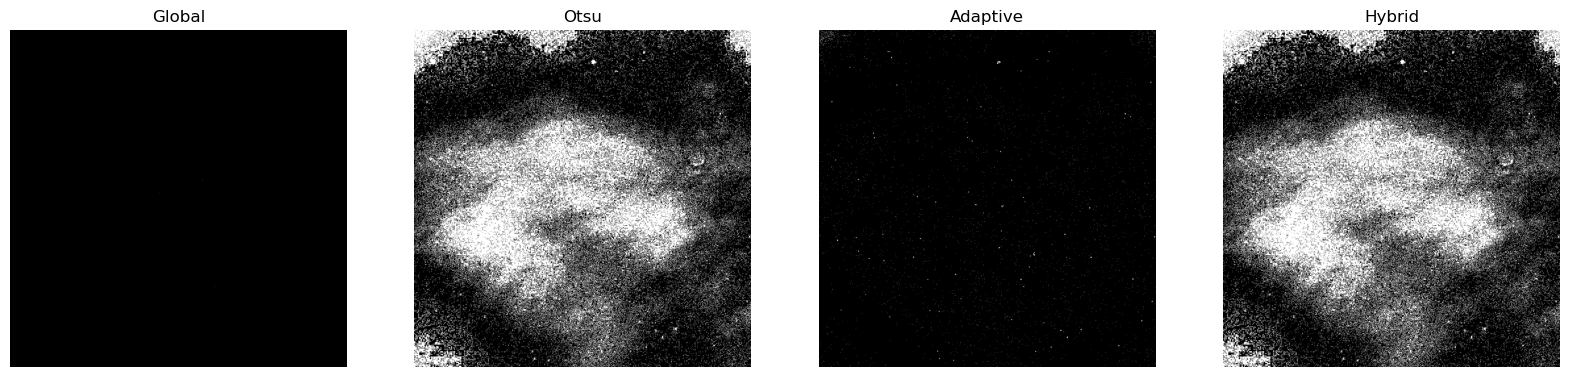

In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def threshold(frame, method='otsu', global_thresh=50):
    # Check if the frame is grayscale
    if len(frame.shape) == 3:
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    if method == 'global':
        _, bw = cv.threshold(frame, global_thresh, 255, cv.THRESH_BINARY)
    elif method == 'otsu':
        _, bw = cv.threshold(frame, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    elif method == 'adaptive':
        bw = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, -2)
    elif method == 'hybrid':
        _, bw1 = cv.threshold(frame, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        bw2 = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, -2)
        bw = cv.bitwise_or(bw1, bw2)
    else:
        raise ValueError('Invalid thresholding method')
    
    return bw

# Function to display a montage of thresholded images
def display_thresholds(frame):
    methods = ['global', 'otsu', 'adaptive', 'hybrid']
    titles = ['Global', 'Otsu', 'Adaptive', 'Hybrid']
    global_thresh = 50

    fig, axes = plt.subplots(1, len(methods), figsize=(20, 5))
    
    for ax, method, title in zip(axes, methods, titles):
        img = threshold(frame, method=method, global_thresh=global_thresh)
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.show()


# Open the video file
video_file = "Videos/5X Ph 9Fps Wash 1 16 60S P019as R1_adj.mp4"

cap = cv.VideoCapture(video_file)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Video not opened")
else:
    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if ret:
        # Display the montage of thresholded images
        display_thresholds(frame)

    else:
        print("Error: Could not read frame.")

# Release the video capture object
cap.release()


## Binary File Saving Options

Save as human readable .csv, and binary parquet file - will save space for larger .csv's 

In [10]:
def save_dataframe(df, file_name_base):
    """
    Save a DataFrame as both .csv and .parquet files.

    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    file_name_base (str): The base file name to use for saving (without extension).
    """
    # Save as CSV
    csv_file = f"{file_name_base}.csv"
    df.to_csv(csv_file, index=False)
    print(f"DataFrame saved as {csv_file}")

    # Save as Parquet
    # Note: Requires installation of the fastparquet pandas dependency
    parquet_file = f"{file_name_base}.parquet"
    df.to_parquet(parquet_file, index=False)
    print(f"DataFrame saved as {parquet_file}")

# Save the dataframe
save_dataframe(df_morph, '10X_-ph_9fps_R1')

DataFrame saved as 10X_-ph_9fps_R1.csv
DataFrame saved as 10X_-ph_9fps_R1.parquet


## Sandbox for trackpy utils

[Documentation](https://soft-matter.github.io/trackpy/dev/index.html)

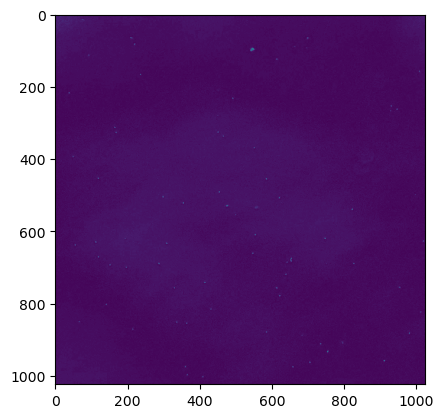

In [14]:
#Load the video (Utils)
# Load the video and save the first frame as a PNG
def loadVideo(videofile, as_gray=True):
    cap = cv.VideoCapture(videofile)
    frames = []
    first_frame_saved = False  # Indicator to ensure the first frame is saved only once
    while True:
        ret, frame = cap.read()
        if frame is None:
            break
        if as_gray:
            frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frames.append(frame)
        # Save the first frame as PNG in the same directory as the video
        if not first_frame_saved:
            first_frame_path = os.path.splitext(videofile)[0] + '_first_frame.png'
            cv.imwrite(first_frame_path, frame)
            first_frame_saved = True
    cap.release()
    frames = np.array(frames)
    return frames


# Run the program
video = loadVideo("Videos/5X Ph 9Fps Wash 1 16 60S P019as R1_adj.mp4")

plt.imshow(video[0])

Frame 4: 77 features


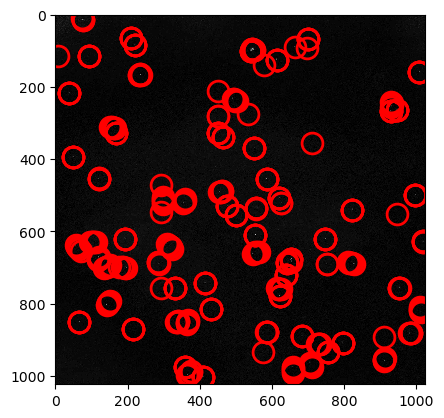

<Axes: >

In [77]:
#Centroid detection function
def determineCentroids(frames, diameter=5, minmass=18, maxsize=10):
    f = tp.batch(frames, diameter=diameter, minmass=minmass, maxsize=maxsize)
    return f

df_track = determineCentroids(video[0:5]) # track performance for a specified set of frames in the video; enables testing parameters
tp.annotate(df_track, video[0], invert=False) # Check the annotation in the first frame

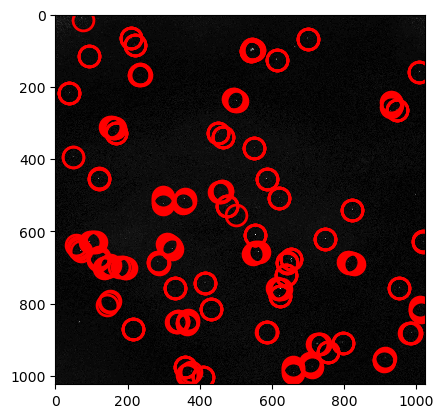

<Axes: >

In [40]:
# Check the annotation in the indicated frame
tp.annotate(df_track, video[4])

## Feed through the unified framework pipeline

In [ ]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

In [ ]:
importlib.reload(tracker)

final = tracker.segmentCells(frames, t)

print(final.head())

In [ ]:
utils.saveDataFrame(final, videofile.split('.')[0] + '_tracked.csv')

### Feed through the statistics pipeline

In [4]:
importlib.reload(stats)

final_withstats = stats.calcAverageSpeed(final)

print(final_withstats.head())

In [ ]:
utils.saveDataFrame(final_withstats, videofile.split('.')[0] + '_tracked_withstats.csv')

### Use Visualizations

In [ ]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final_withstats, visualization="segments")